In [1]:
# Wrangling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sb
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from xgboost import plot_importance
from matplotlib.pyplot import figure

figure(figsize=(15, 8), dpi=80)

In [2]:
def gen_model_report(clf: xgb.XGBClassifier, Y_test: np, y_pred:np) -> None:
    """
    Generates Classification Report and Confusion Matrix for the classifier/model
    
    Args:
        clf (xgb classifier): XGB classifier
        Y_test (numpy array): Test set data
        y_pred (numpy array): Classifier/mode predicted data
        
    Returns:
        None
    """
    
    # Display classification report
    print("Displaying Classification Report:")
    print(classification_report(y_true=Y_test, y_pred=y_pred))
    
    # Generate confusion matrix
    con_matrix = confusion_matrix(y_true=Y_test,
                     y_pred=y_pred)
    
    # Display confusion matrix
    print("Displaying Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                                  display_labels=xgb_classifier.classes_)
    disp.plot()

## Data

In [3]:
# load data and provide headers
# Target variable is buying_price
data = pd.read_csv("../data/car.data",
                  names=["buying_price", 
                         "maintenance_price", 
                         "num_of_doors",
                         "num_of_people",
                         "lug_boot",
                         "safety",
                         "acceptability"])

In [4]:
# Check loaded data
data.head()

,buying_price,maintenance_price,num_of_doors,num_of_people,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying_price       1728 non-null   object
 1   maintenance_price  1728 non-null   object
 2   num_of_doors       1728 non-null   object
 3   num_of_people      1728 non-null   object
 4   lug_boot           1728 non-null   object
 5   safety             1728 non-null   object
 6   acceptability      1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [6]:
list(data.buying_price.unique())

['vhigh', 'high', 'med', 'low']

In [7]:
# 7 categorical variables
data.dtypes.value_counts()

object    7
dtype: int64

In [8]:
# Extract target variable
x = data.drop("buying_price",
                   axis=1)

ml_target = data["buying_price"].values
label_encode = LabelEncoder()
y = label_encode.fit_transform(ml_target)

## Encoders

In [9]:
# Determine values in ordinal values 
print("Maintenance price categories: {}".format(list(data["maintenance_price"].unique())))
print("Lug boo categories: {}".format(list(data["lug_boot"].unique())))
print("Safety categories: {}".format(list(data["safety"].unique())))
print("Acceptability categories: {}".format(list(data["acceptability"].unique())))

# Rearrange ordinal values
maintenance_price_cat = ['low', 'med', 'high', 'vhigh']
lug_boot_cat = ['small', 'med', 'big']
safety_cat = ['low', 'med', 'high']
acceptability_cat = ['unacc', 'acc', 'good', 'vgood']

Maintenance price categories: ['vhigh', 'high', 'med', 'low']
Lug boo categories: ['small', 'med', 'big']
Safety categories: ['low', 'med', 'high']
Acceptability categories: ['unacc', 'acc', 'vgood', 'good']


In [10]:
# Onehot encoder
onehot_encoder = OneHotEncoder(sparse=False, categories="auto")

In [11]:
onehot_encoder.fit_transform(x[["num_of_doors", "num_of_people"]])[:2]

array([[1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.]])

In [12]:
onehot_encoder.categories_

[array(['2', '3', '4', '5more'], dtype=object),
 array(['2', '4', 'more'], dtype=object)]

In [13]:
# Ordinal encode
ordinal_encoder = OrdinalEncoder(
    categories=[
        maintenance_price_cat,
        lug_boot_cat,
        safety_cat,
        acceptability_cat
    ]
)

In [14]:
ordinal_encoder.fit_transform(x[["maintenance_price", "lug_boot", "safety", "acceptability"]])[:2]

array([[3., 0., 0., 0.],
       [3., 0., 1., 0.]])

## Generate Dataset

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (1209, 6)
Y_train shape:  (1209,)
X_test shape:  (519, 6)
Y_test shape:  (519,)


## Baseline Model Pipeline

In [16]:
# Definde column transformer
transformer = make_column_transformer(
    (onehot_encoder, ["num_of_doors", "num_of_people"]),
    (ordinal_encoder, ["maintenance_price", "lug_boot", "safety", "acceptability"])
)                

In [17]:
# Test
transformer.fit_transform(x)[:2]

array([[1., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 3., 0., 1., 0.]])

In [18]:
xgb_classifier = xgb.XGBClassifier(eval_metric="mlogloss",
                                  objective="multi:softmax")

In [19]:
# Define pipeline
pipeline = Pipeline(steps=[
        ('preprocess', transformer),
        ('xgb_clf', xgb_classifier)
    ]
)

In [20]:
eval_set = [(transformer.fit_transform(X_test), Y_test)]
pipeline.fit(X_train, Y_train, xgb_clf__eval_set=eval_set)

[0]	validation_0-mlogloss:1.35723
[1]	validation_0-mlogloss:1.34415
[2]	validation_0-mlogloss:1.33860
[3]	validation_0-mlogloss:1.34001
[4]	validation_0-mlogloss:1.34720
[5]	validation_0-mlogloss:1.35588
[6]	validation_0-mlogloss:1.36360
[7]	validation_0-mlogloss:1.37131
[8]	validation_0-mlogloss:1.38085
[9]	validation_0-mlogloss:1.39196
[10]	validation_0-mlogloss:1.39923
[11]	validation_0-mlogloss:1.41127
[12]	validation_0-mlogloss:1.42172
[13]	validation_0-mlogloss:1.43382
[14]	validation_0-mlogloss:1.44735
[15]	validation_0-mlogloss:1.45814
[16]	validation_0-mlogloss:1.46763
[17]	validation_0-mlogloss:1.47703
[18]	validation_0-mlogloss:1.48487
[19]	validation_0-mlogloss:1.49565
[20]	validation_0-mlogloss:1.50687
[21]	validation_0-mlogloss:1.51735
[22]	validation_0-mlogloss:1.52803
[23]	validation_0-mlogloss:1.53825
[24]	validation_0-mlogloss:1.55341
[25]	validation_0-mlogloss:1.56651
[26]	validation_0-mlogloss:1.57851
[27]	validation_0-mlogloss:1.59266
[28]	validation_0-mlogloss:1.6

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['num_of_doors',
                                                   'num_of_people']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high',
                                                                              'vhigh'],
                                                                             ['small',
                                                                              'med',
                                                                              'big'],
                

## Baseline Model results

In [21]:
y_pred = xgb_classifier.predict(transformer.fit_transform(X_test))

Displaying Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.02      0.02       133
           1       0.15      0.13      0.14       135
           2       0.06      0.07      0.07       124
           3       0.09      0.09      0.09       127

    accuracy                           0.08       519
   macro avg       0.08      0.08      0.08       519
weighted avg       0.08      0.08      0.08       519

Displaying Confusion Matrix:


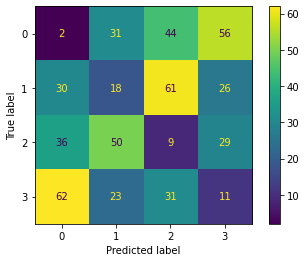

In [22]:
gen_model_report(xgb_classifier, Y_test, y_pred)

In [ ]:
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

## Baseline: 8%

## Improve Model

In [41]:
prefix = "xgb_clf__"
parameters = {
    f"{prefix}learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    f"{prefix}n_estimators": [100, 400, 500, 600, 1000],
    f"{prefix}max_depth": [3, 4, 5, 6, 7, 8]
}

In [42]:
grid = GridSearchCV(pipeline, parameters, cv=10).fit(X_train, Y_train)

In [36]:
print('Training set score: ' + str(grid.score(X_train, Y_train)))
print('Test set score: ' + str(grid.score(X_test, Y_test)))

Training set score: 0.44499586435070304
Test set score: 0.1464354527938343


In [43]:
print('Training set score: ' + str(grid.score(X_train, Y_train)))
print('Test set score: ' + str(grid.score(X_test, Y_test)))

Training set score: 0.3564929693961952
Test set score: 0.3044315992292871


In [44]:
best_params = grid.best_params_
print(best_params)

{'xgb_clf__learning_rate': 0.01, 'xgb_clf__max_depth': 3, 'xgb_clf__n_estimators': 100}


In [45]:
best_pipe = grid.best_estimator_
print(best_pipe)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['num_of_doors',
                                                   'num_of_people']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high',
                                                                              'vhigh'],
                                                                             ['small',
                                                                              'med',
                                                                              'big'],
                

In [48]:
y_pred = xgb_classifier.predict(transformer.fit_transform(X_test))

Displaying Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.02      0.02       133
           1       0.15      0.13      0.14       135
           2       0.06      0.07      0.07       124
           3       0.09      0.09      0.09       127

    accuracy                           0.08       519
   macro avg       0.08      0.08      0.08       519
weighted avg       0.08      0.08      0.08       519

Displaying Confusion Matrix:


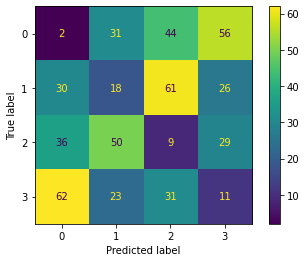

In [49]:
gen_model_report(xgb_classifier, Y_test, y_pred)

In [51]:
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 7.71
